In [9]:
# Importing libraries
from data_driven.modeling.scripts.tuning import parameter_tuning
from data_driven.modeling.scripts.ancillary import (drive_authentication, npz_files, open_dataset,
                                                    build_base_model, save_best_params)

from skopt.space import Integer, Categorical
from skopt.plots import plot_convergence
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import time

# 1. Accessing the data 

If you will use Google Drive, you have to enable Google Drive and obtain the client secrets file client_secrets.json (see the following [link](https://developers.google.com/drive/api/v3/enable-drive-api) or [this other](https://www.geeksforgeeks.org/get-list-of-files-and-folders-in-google-drive-storage-using-python/))

In [2]:
# Connecting to Google Drive
# client_secrets.json need to be in the same directory as the script

drive = drive_authentication()

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=128273080156-gak8id4v61mj7jjdqqucv74kc5volhj0.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


If you need to check the folder on where you have stored the data for running the multi-class classification algorithm, use the folder ID and the function just below

In [3]:
# When you share a folder/file from Google Drive by using its shareable link you will see tomething like 
# https://drive.google.com/drive/folders/{ID_element}?usp=sharing. You can take the ID_element

multi_class_data_folder_id = '1hoUT3WQxblQJWm-8v-9EKLJZ4614JVtI'
ids = npz_files(multi_class_data_folder_id, drive)
ids

{'3': '18KrIiGmRn90uCNchktAWDPRa8wl2qKyO',
 '2': '1pAgEm3u5_spuniqBBfFta3EK2xPuLQc3',
 '1': '1bGA6Zuvez9weG0sZglM6nFpphSMjdl8D'}

# 2. Building RFC with default parameters

In [4]:
# Default parameters
model_params = {
    'bootstrap': True,
    'ccp_alpha': 0.0,
    'class_weight': 'balanced',
    'criterion': 'gini',
    'max_depth': None,
    'max_features': 'sqrt',
    'max_leaf_nodes': None,
    'max_samples': None,
    'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0,
    'n_estimators': 100,
    'n_jobs': 4,
    'oob_score': False,
    'random_state': 0,
    'verbose': 0,
    'warm_start': False,
}

In [5]:
df_results = pd.DataFrame()

for id, key in ids.items():
    
    print(f'Evaluating base model for data preparation id {id}\n')
    
    # Opening the dataset
    X_train, Y_train = open_dataset(id, key, drive, test=False)
    
    # Y-randomization and cross-validation
    df_results = pd.concat([df_results,
                            build_base_model(id, X_train, Y_train.reshape(Y_train.shape[0],),
                                            model_params, 'RFC', 'multi-class classification'
                                            )
                           ],
                          axis=0,
                          ignore_index=True)

Evaluating base model for data preparation id 3

X train has the following dimensions: (486440, 83)
Y train has the following dimensions: (486440, 1)


Y-Randomization: 100%|██████████| 10/10 [08:17<00:00, 49.72s/it]


Evaluating base model for data preparation id 2

X train has the following dimensions: (486440, 79)
Y train has the following dimensions: (486440, 1)


Y-Randomization: 100%|██████████| 10/10 [07:22<00:00, 44.30s/it]


Evaluating base model for data preparation id 1

X train has the following dimensions: (59070, 62)
Y train has the following dimensions: (59070, 1)


Y-Randomization: 100%|██████████| 10/10 [02:46<00:00, 16.69s/it]


In [6]:
df_results

,mean_validation_accuracy,mean_train_accuracy,accuracy_analysis,mean_validation_f1,mean_train_f1,mean_validation_0_1_loss_or_error,std_validation_0_1_loss_or_error,y_randomization_mean_0_1_loss_or_error,y_randomization_std_0_1_loss_or_error,id
0,0.45,0.80,over-fitting (high variance),0.45,0.80,0.55,0.000953,0.9,0.001091,3
1,0.45,0.80,over-fitting (high variance),0.45,0.80,0.55,0.000683,0.9,0.000835,2
2,0.40,0.77,over-fitting (high variance),0.40,0.77,0.60,0.001734,0.9,0.002348,1


# 3. Selection of best data preprocessing

Model performance, explainability, and time are three important factors to be considered.

1. Explainability: from the point of view of the model, as the three pipelines use RFC, the explainability depends on the features. FAMD reduces the dimensionality by transforming the original features into new orthogonal ones. Thus, it is not possible to make inferences directly about the importance of the original feature.
2. Performance: as shown in the above results, the default RFC presents overfitting for the three preprocessing pipelines and their performances are similar, with the pipeline id 1 a little worse than the others.
3. Time: for Y randomization and cross validation, the pipeline id 1 required around 208 seconds. Nonetheless, the ratio between time and samples for pipeline 2 is the lowest (around 0.00127 sec/samples). This pepilene could represent the lower time per sample for tuning and prediction for serving models, considering that the pipeline 1 that uses FAMD will require additional time in order to transform the original feature to the new feature space.

Thus, it is not complicated to decide for its performance, time for processing a sample, and explainability to select the pipeline id 2.



# 4. Tuning the model

In [4]:
# Opening the dataset
X_train, Y_train, X_test, Y_test = open_dataset('2', '1pAgEm3u5_spuniqBBfFta3EK2xPuLQc3', drive, test=True)

X train has the following dimensions: (486440, 79)
Y train has the following dimensions: (486440, 1)
X test has the following dimensions: (67159, 79)
Y test has the following dimensions: (67159, 1)


In [5]:
# Fixed parameters
model_params = {
    'ccp_alpha': 0.0,
    'class_weight': 'balanced',
    'max_leaf_nodes': None,
    'max_samples': None,
    'min_impurity_decrease': 0.0,
    'min_weight_fraction_leaf': 0.0,
    'n_jobs': 4,
    'oob_score': False,
    'random_state': 0,
    'verbose': 0,
    'warm_start': False,
    'bootstrap': True
}

In [6]:
# For tuning
search_space = [Integer(1, 50, name='min_samples_leaf'),
                Integer(2, 50, name='min_samples_split'), 
                Categorical(['log2', 'sqrt'], name='max_features'),
                Integer(10, 2000, name='n_estimators'),
                Integer(10, 200, name='max_depth'),
                Categorical(['gini', 'entropy'], name='criterion')]

In [7]:
# Tuning
# We run Bayesian Optimization with Gaussian Processes, which uses a Multidimensional Gaussian distribution as surrogate model.
# The objective function is the negative of the the mean f1 score for 5-fold cross-validation
# A threshold of 0.75 for the f1 score to stop the optimization is used
# n_iter_search = number of iterations for the Bayesian Optimization
# time_to_optimize = the budget time to optimize the Bayesian Optimization

start = time.time()

tuning_result = parameter_tuning(X_train, Y_train.reshape(Y_train.shape[0],),
                                'RFC', model_params,
                                search_space,
                                'multi-class classification',
                                time_to_optimize=36000,
                                n_iter_search=200,
                                threshold=0.75, 
                                verbose=False)

end = time.time()

best_params = {'model': 'RFC': ['params': {**tuning_result['best_params'], **model_params}]}

# Saving the best parameters
save_best_params('multi-class_classification', best_params)

print(f'The best model mean validation f1 is {tuning_result["best_mean_validation_f1"]}')
print(f'The time actually spent for tuning {end - start} seconds')  

The best model mean validation f1 is 0.49


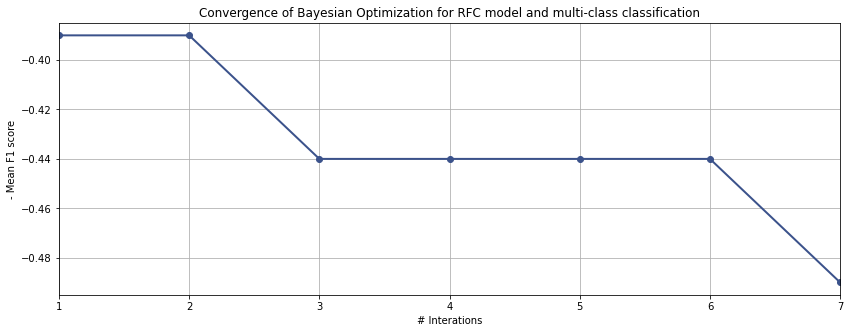

In [8]:
plt.figure(figsize=(14,5))
plot_convergence(tuning_result['search'])
plt.title('Convergence of Bayesian Optimization for RFC model and multi-class classification')
plt.xlabel('# Interations')
plt.ylabel('- Mean F1 score')
plt.xlim(1,len(tuning_result['search'].func_vals))
plt.show()